In [1]:
from loadmodules import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.interpolate import interpn
import matplotlib.colors as colors

%matplotlib inline

In [2]:
parent_dir = './isolated_gal/'
simulations = [directory for directory in os.listdir(parent_dir)]
simulations

['auriga_ism', 'smuggle_ism']

In [3]:
s = gadget_readsnap(30, snappath=parent_dir+simulations[0]+'/output/', applytransformationfacs=True, hdf5=True, loadonlytype=[4])

unit_time = s.UnitLength_in_cm/s.UnitVelocity_in_cm_per_s

gyr = 3.15569e16
solarmass = 1.989e33
kpc = 3.086e21

In [42]:
mask_clusters_initial = s.data['incl'] > 0
mask_clusters_final = s.data['nclt'] > 0

truncation_mass = s.data['mtrc'][mask_clusters_initial]
cluster_masses = s.data['mclt'][mask_clusters_initial].flatten()
cluster_radius = s.data['rclt'][mask_clusters_initial].flatten()
init_cluster_masses = s.data['imcl'][mask_clusters_initial].flatten()
init_cluster_radius = s.data['ircl'][mask_clusters_initial].flatten()
masslostrelax = s.data['mlrx'][mask_clusters_initial].flatten()
masslostshock = s.data['mlsk'][mask_clusters_initial].flatten()

not_empty_clusters = (init_cluster_masses>0)

cluster_masses = cluster_masses[not_empty_clusters]
cluster_radius = cluster_radius[not_empty_clusters]
init_cluster_masses = init_cluster_masses[not_empty_clusters]
init_cluster_radius = init_cluster_radius[not_empty_clusters]
masslostrelax = masslostrelax[not_empty_clusters]
masslostshock = masslostshock[not_empty_clusters]

In [45]:
clusters_birthtime = np.repeat(s.data['age'], s.data['incl'])

In [46]:
clusters_disruptiontime = s.data['drpt'][mask_clusters_initial].flatten()
clusters_disruptiontime = clusters_disruptiontime[not_empty_clusters]

In [47]:
lifetime_gyr = (clusters_disruptiontime - clusters_birthtime) * unit_time / gyr
lifetime_gyr[(lifetime_gyr<0)] = 3.5

In [48]:
msh_mrlx = masslostshock/masslostrelax

min_icmf = 5e3 # in solar masses
max_icmf = 1e8 # in solar masses
marray_icmf = np.logspace(np.log10(min_icmf), np.log10(max_icmf), 25)

min_gcmf = 1e2 # in solar masses
max_gcmf = 1e8 # in solar masses
marray_gcmf = np.logspace(np.log10(min_gcmf), np.log10(max_gcmf), 25)

min_rh = 1e-2 # in parsecs
max_rh = 2e2 # in parsecs
rharray = np.logspace(np.log10(min_rh), np.log10(max_rh), 25) # in pc

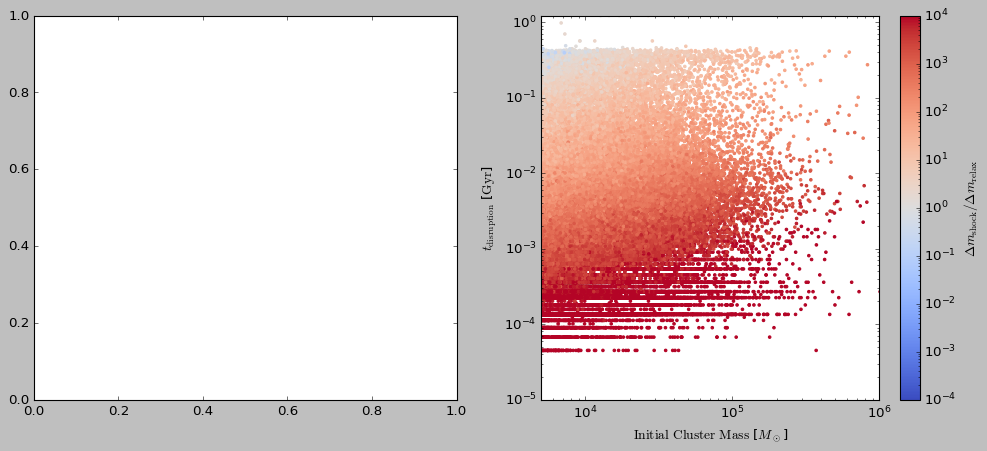

In [49]:
fig, ax = plt.subplots(1,2,figsize=(15, 6))

# TRY WITH projections MODULE

cb = ax[1].scatter(init_cluster_masses*1e10, lifetime_gyr, c = msh_mrlx, edgecolors='face', s=5, cmap=cm.coolwarm, norm=cm.colors.LogNorm(vmin=1e-4, vmax=1e4))
ax[1].set(xscale='log', xlim=(5e3, 1e6), yscale='log', ylim=(1e-5, lifetime_gyr.max()))
ax[1].set(xlabel=r'$\rm{Initial}$ $\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', ylabel=r'$t_{\rm{disruption}}$ [$\rm{Gyr}$]')
cbar = fig.colorbar(cb, ax=ax[1], label=r'$\Delta m_{\rm{shock}}/\Delta m_{\rm{relax}}$')
# ax[1].tick_params(labelsize=12)
# plt.tight_layout()
# plt.savefig('iso_smug_disruption.png')

In [16]:
mevminit = masslostrelax/init_cluster_masses
mshminit = masslostshock/init_cluster_masses

In [17]:
def density_scatter( x , y, vmin, vmax, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density=False)
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    h = ax.scatter( x, y, c=z, norm=colors.LogNorm(vmin=vmin, vmax=vmax),cmap=cm.viridis, **kwargs )

    return ax, h

Text(0, 0.5, 'Inital Cluster Radius [pc]')

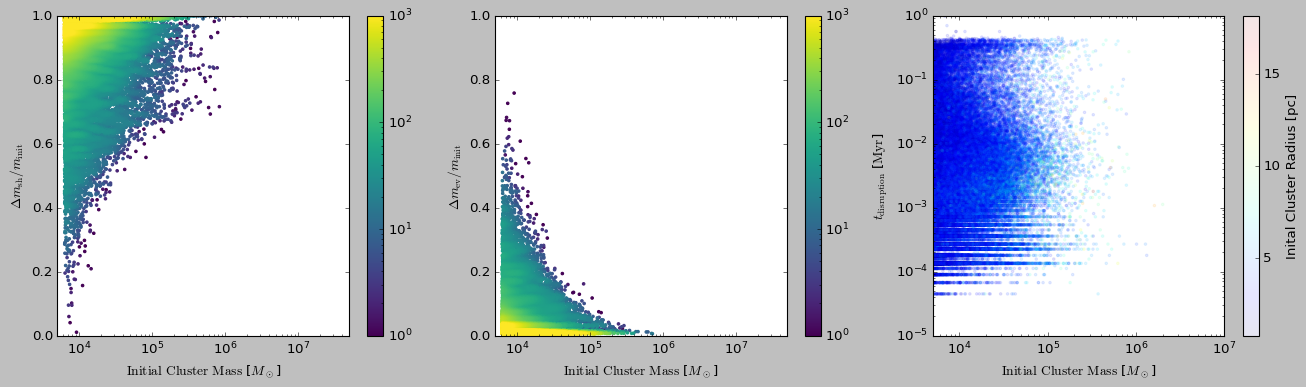

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
ax[0], cb1 = density_scatter(init_cluster_masses*1e10, mshminit, vmin=1e0, vmax=1e3, ax=ax[0],bins=[marray_icmf, np.linspace(0,1.1,100)], edgecolors='face', s=5)
ax[0].set(xscale='log', xlim=(5e3, 5e7), ylim=(0,1), xlabel=r'$\rm{Initial}$ $\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', ylabel=r'$\Delta m_{\rm{sh}}/m_{\rm{init}}$')
cbar = fig.colorbar(cb1, ax=ax[0])

ax[1], cb1 = density_scatter(init_cluster_masses*1e10, mevminit, vmin=1e0, vmax=1e3, ax=ax[1],bins=[marray_icmf, np.linspace(0,1.1,100)], edgecolors='face', s=5)
ax[1].set(xscale='log', xlim=(5e3, 5e7), ylim=(0,1), xlabel=r'$\rm{Initial}$ $\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', ylabel=r'$\Delta m_{\rm{ev}}/m_{\rm{init}}$')
cbar = fig.colorbar(cb1, ax=ax[1])

cb2 = ax[2].scatter(init_cluster_masses*1e10, lifetime_gyr, c=init_cluster_radius*1e3, edgecolors='face', s=5, alpha=0.1)
ax[2].set(xscale='log', yscale='log', xlim=(5e3, 1e7), ylim=(1e-5, 1e0))
ax[2].set(xlabel=r'$\rm{Initial}$ $\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', ylabel=r'$t_{\rm{disruption}}$ [$\rm{Myr}$]')
cbar = fig.colorbar(cb2, ax=ax[2])
cbar.ax.set_ylabel('Inital Cluster Radius [pc]')

In [26]:
s = gadget_readsnap(30, snappath=parent_dir+simulations[1]+'/output/', loadonlytype=[0,4,5], loadonly=['pos','vol','rho','mass','vel', 'vol'] )
tcolor='w'

In [29]:
s.data['rho'].max()

np.float32(1.17563275e-07)

s= 4.5
Selected 2743261 of 2743262 particles.
nz= 128 zdist=500, boxx=1000.000000, boxy=1000
Total is  0.2801464675251276
Selected 959311 of 2743262 particles.
nz= 128 zdist=500, boxx=1000.000000, boxy=500


/users/aripcont/.local/lib/python3.10/site-packages/projections.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cax.set_xticklabels(["$\\rm{10^{%d}}$"%ticks for ticks in np.log10(xticks)])


Total is  0.19057211741924415


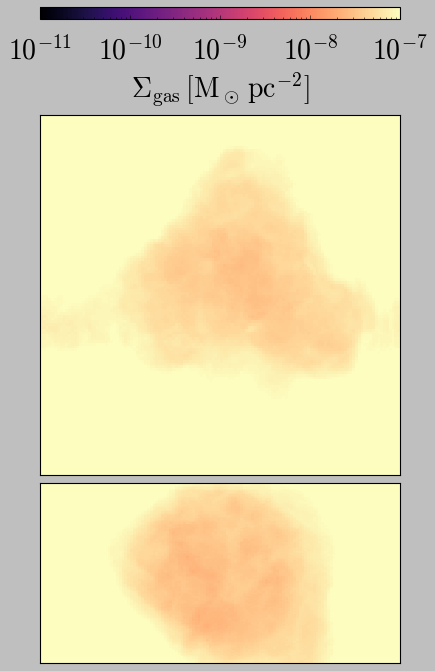

In [31]:
figsize = 6
ncols = 1
nrows = 1
res = 128
boxsize = 1000
f = plt.figure( FigureClass=sfig, figsize=( figsize*ncols, figsize*1.5*nrows ) )
ax, ax2, x, y, y2, area = create_axis( f, 0, ncol=ncols, res=res, boxsize=boxsize, cb=True )

vmin = 1e-11
vmax = 1e-7
rsph = 50
axes1 = [0,1]
axes2 = [0,2]

zres = 128
depth = 0.01

proj = s.get_Aslice( "rho", res=res, axes=axes1, box=[boxsize,boxsize], proj=True, numthreads=8 )["grid"] * boxsize / res * 1e10 / 1e12  #/ (area) / 1e2#* boxsize*1e3
#proj = s.plot_Aslice( "rho", colorbar=False, res=res, proj=True, axes=axes1, box=[boxsize,boxsize], proj_fact=0.5, logplot=True, rasterized=True, newfig=False, dextoshow=6, numthreads=numthreads )["grid"]*boxsize*1e3
pc = ax.pcolormesh( x, y, np.flipud(proj.T), norm=matplotlib.colors.LogNorm( vmin=vmin, vmax=vmax ), cmap=matplotlib.cm.magma, rasterized=True)#, shading='flat' )
create_colorbar( f, pc, "$\mathrm{\Sigma _{gas} \, [M_\odot\,pc^{-2}]}$")#, ncol=15)#, orientation='vertical' )

proj = s.get_Aslice( "rho", res=res, axes=axes2, box=[boxsize,boxsize/2.], proj=True, proj_fact=0.5, numthreads=8)["grid"]  * boxsize / res * 1e10 / 1e12#* boxsize*1e3
ax2.pcolormesh( x, 0.5*y, np.flipud(proj.T), norm=matplotlib.colors.LogNorm( vmin=vmin, vmax=vmax ), cmap=matplotlib.cm.magma, rasterized=True)#, shading='flat' )


ax.set_xticks([])
ax.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])

pix_per_kpc = boxsize / (x.max() - x.min())